### Data Exploration
- We've scraped football data from fbref website and also we added 2 new columns generated (Home Team Goal Difference and Away Team Goal Difference)

In [2804]:
!pip install ipykernel matplotlib scikit-learn pandas numpy seaborn requests xgboost

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# List of csv files (datasets)
csv_files = ['matches-2023-2024.csv', 'matches-2022-2023.csv', 'matches-2021-2022.csv', 'matches-2024-2025.csv']

df_list = [pd.read_csv(file) for file in csv_files]
matches = pd.concat(df_list, ignore_index=True)
# matches = pd.read_csv('matches-2023-2024.csv')

df = matches.copy()

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort dataframe by Date in ascending order
df = df.sort_values(by="Date").reset_index(drop=True)
df.drop(columns=['Time'], inplace=True)

df.tail()

,Date,Home Team,XGH,Away Team,XGA,Score,FTHG,FTAG,HTGDIFF,ATGDIFF,Result,Referee,STH,STA,PH,PA
1417,2025-03-09,Chelsea,1.7,Leicester City,0.1,1–0,1,0,1,-1,1,Tim Robinson,6,3,56,44
1418,2025-03-09,Tottenham,1.5,Bournemouth,2.2,2–2,2,2,0,0,X,John Brooks,3,8,61,39
1419,2025-03-09,Manchester Utd,1.5,Arsenal,1.6,1–1,1,1,0,0,X,Anthony Taylor,6,6,32,68
1420,2025-03-10,West Ham,0.7,Newcastle Utd,1.4,0–1,0,1,-1,1,2,Michael Salisbury,2,3,51,49
1421,2025-03-16,Leicester City,0.0,Manchester United,0.0,0-0,0,0,0,0,1,Anthony Taylor,0,0,50,50


In [2805]:
df.head()

,Date,Home Team,XGH,Away Team,XGA,Score,FTHG,FTAG,HTGDIFF,ATGDIFF,Result,Referee,STH,STA,PH,PA
0,2021-08-13,Brentford,1.2,Arsenal,1.3,2–0,2,0,2,-2,1,Michael Oliver,3,4,36,64
1,2021-08-14,Norwich City,1.4,Liverpool,1.6,0–3,0,3,-3,3,2,Andre Marriner,3,6,50,50
2,2021-08-14,Everton,2.4,Southampton,0.8,3–1,3,1,2,-2,1,Andy Madley,6,3,48,52
3,2021-08-14,Watford,1.2,Aston Villa,1.2,3–2,3,2,1,-1,1,Mike Dean,7,1,38,62
4,2021-08-14,Manchester Utd,1.5,Leeds United,0.5,5–1,5,1,4,-4,1,Paul Tierney,8,3,49,51


In [2806]:
# Function to calculate average goal difference for home and away teams
def avg_stats(df, avg_xg_col, team, xg_col, matches):
    all_teams = df[team].unique()
    
    df[avg_xg_col] = 0.0  # Ensure it's float to store rolling averages

    for t in all_teams:
        df_team = df[df[team] == t].copy()  # Filter by team
        df_team[avg_xg_col] = df_team[xg_col].rolling(window=matches, min_periods=1).median().shift(1).fillna(0)
        
        df.update(df_team[[avg_xg_col]])

# Apply function for Home and Away teams
avg_stats(df, "AVGHGD", "Home Team", "HTGDIFF", 30)
avg_stats(df, "AVGAGD", "Away Team", "ATGDIFF", 30)

# Apply function for Home and Away teams
avg_stats(df, "AVGHXG", "Home Team", "XGH", 20)
avg_stats(df, "AVGAXG", "Away Team", "XGA", 20)

# Apply function for shoots on target last 
avg_stats(df, "AVGSTH", "Home Team", "STH", 30)
avg_stats(df, "AVGSTA", "Away Team", "STA", 30)

# Apply function for shoots on target last 
avg_stats(df, "AVGPH", "Home Team", "PH", 30)
avg_stats(df, "AVGPA", "Away Team", "PA", 30)

In [2807]:
import pandas as pd

def calculate_average_points_per_game(df):
    # Dictionary to track total points and games played for each team
    team_stats = {}

    # Lists to store calculated PPG for home and away teams
    home_ppg_list = []
    away_ppg_list = []

    for index, row in df.iterrows():
        home_team = row["Home Team"]
        away_team = row["Away Team"]
        result = row["Result"]

        # Assign points based on match result
        if result == "1":  # Home win
            home_points, away_points = 3, 0
        elif result == "2":  # Away win
            home_points, away_points = 0, 3
        else:  # Draw
            home_points, away_points = 1, 1

        # Update home team stats
        if home_team not in team_stats:
            team_stats[home_team] = {"points": 0, "games": 0}
        team_stats[home_team]["points"] += home_points
        team_stats[home_team]["games"] += 1

        # Update away team stats
        if away_team not in team_stats:
            team_stats[away_team] = {"points": 0, "games": 0}
        team_stats[away_team]["points"] += away_points
        team_stats[away_team]["games"] += 1

        # Compute average PPG
        home_ppg = team_stats[home_team]["points"] / team_stats[home_team]["games"]
        away_ppg = team_stats[away_team]["points"] / team_stats[away_team]["games"]

        # Append to lists
        home_ppg_list.append(round(home_ppg, 2))
        away_ppg_list.append(round(away_ppg, 2))

    # Add PPG columns to the DataFrame
    df["Home PPG"] = home_ppg_list
    df["Away PPG"] = away_ppg_list

    return df

# Example usage with your dataset
df = calculate_average_points_per_game(df)  # Calculate PPG

print(df.head(50))  # Display updated dataframe

         Date        Home Team  XGH        Away Team  XGA Score  FTHG  FTAG  \
0  2021-08-13        Brentford  1.2          Arsenal  1.3   2–0     2     0   
1  2021-08-14     Norwich City  1.4        Liverpool  1.6   0–3     0     3   
2  2021-08-14          Everton  2.4      Southampton  0.8   3–1     3     1   
3  2021-08-14          Watford  1.2      Aston Villa  1.2   3–2     3     2   
4  2021-08-14   Manchester Utd  1.5     Leeds United  0.5   5–1     5     1   
5  2021-08-14          Burnley  1.5         Brighton  1.0   1–2     1     2   
6  2021-08-14   Leicester City  0.5           Wolves  1.3   1–0     1     0   
7  2021-08-14          Chelsea  0.7   Crystal Palace  0.2   3–0     3     0   
8  2021-08-15    Newcastle Utd  1.8         West Ham  2.7   2–4     2     4   
9  2021-08-15        Tottenham  1.0  Manchester City  1.8   1–0     1     0   
10 2021-08-21         Brighton  1.3          Watford  0.5   2–0     2     0   
11 2021-08-21   Crystal Palace  0.5        Brentford

In [2808]:
team_name = "Arsenal"

# Filter matches where Arsenal is either home or away
arsenal_matches = df[(df["Home Team"] == team_name)].copy()

# Extract only the next 10 matches
arsenal_matches.head(10)

,Date,Home Team,XGH,Away Team,XGA,Score,FTHG,FTAG,HTGDIFF,ATGDIFF,...,AVGHGD,AVGAGD,AVGHXG,AVGAXG,AVGSTH,AVGSTA,AVGPH,AVGPA,Home PPG,Away PPG
17,2021-08-22,Arsenal,0.3,Chelsea,3.1,0–2,0,2,-2,2,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,3.00
34,2021-09-11,Arsenal,2.7,Norwich City,0.7,1–0,1,0,1,-1,...,-2.0,-5.0,0.30,0.10,3.0,0.0,35.0,33.0,0.75,0.00
58,2021-09-26,Arsenal,1.1,Tottenham,1.0,3–1,3,1,2,-2,...,-0.5,-1.0,1.50,0.90,4.5,3.0,43.0,40.0,1.50,1.50
79,2021-10-18,Arsenal,1.7,Crystal Palace,0.7,2–2,2,2,0,0,...,1.0,-3.0,1.10,0.60,6.0,2.0,46.0,41.0,1.38,1.00
80,2021-10-22,Arsenal,2.7,Aston Villa,1.4,3–1,3,1,2,-2,...,0.5,-1.0,1.40,1.20,6.0,3.0,48.5,43.5,1.56,1.11
109,2021-11-07,Arsenal,1.6,Watford,0.5,1–0,1,0,1,-1,...,1.0,-1.0,1.70,0.80,6.0,2.0,51.0,44.0,1.82,0.91
120,2021-11-27,Arsenal,2.5,Newcastle Utd,0.3,2–0,2,0,2,-2,...,1.0,-0.5,1.65,0.50,6.0,1.5,52.0,42.0,1.77,0.46
152,2021-12-11,Arsenal,1.8,Southampton,0.6,3–0,3,0,3,-3,...,1.0,-1.0,1.70,1.00,6.0,3.0,53.0,52.0,1.62,1.00
162,2021-12-15,Arsenal,2.8,West Ham,0.4,2–0,2,0,2,-2,...,1.5,0.5,1.75,1.00,6.0,3.5,53.5,55.5,1.71,1.65
185,2022-01-01,Arsenal,0.8,Manchester City,2.0,1–2,1,2,-1,1,...,2.0,1.0,1.80,1.75,6.0,6.0,54.0,64.5,1.75,2.52


In [2809]:
# Test the function above it's working as expected

liverpool_games = df[df["Away Team"] == "Liverpool"][["Date", "Away Team", "ATGDIFF", "AVGAGD"]]
print(liverpool_games)
liverpool_past_games = liverpool_games.iloc[0:5]["ATGDIFF"]
print("Liverpool's Past ATGDIFF:\n", liverpool_past_games)

expected_median = liverpool_past_games.median()
print("Expected Median:", expected_median)

correct_index = liverpool_games.index[5]  # 6th match index in the original df
computed_avgagd = df.loc[correct_index, "AVGAGD"]
print("Computed AVGAGD:", computed_avgagd)


           Date  Away Team  ATGDIFF  AVGAGD
1    2021-08-14  Liverpool        3     0.0
38   2021-09-12  Liverpool        3     3.0
50   2021-09-25  Liverpool        0     3.0
75   2021-10-16  Liverpool        5     3.0
87   2021-10-24  Liverpool        5     3.0
...         ...        ...      ...     ...
1351 2025-01-18  Liverpool        2     1.0
1373 2025-02-01  Liverpool        2     1.0
1379 2025-02-12  Liverpool        0     1.0
1390 2025-02-19  Liverpool        0     1.0
1400 2025-02-23  Liverpool        2     1.0

[72 rows x 4 columns]
Liverpool's Past ATGDIFF:
 1     3
38    3
50    0
75    5
87    5
Name: ATGDIFF, dtype: int64
Expected Median: 3.0
Computed AVGAGD: 3.0


In [2810]:
# def head_to_head_form(df):
#     # Create a column for head-to-head result form
#     df['HTH_Form'] = ""  # Initialize with empty strings
    
#     # Temporarily convert "Result" column to numeric (convert to 1, 0, -1 for win, draw, loss)
#     temp_result = pd.to_numeric(df["Result"], errors="coerce")  # Convert to numeric temporarily
    
#     for idx, row in df.iterrows():
#         home_team = row["Home Team"]
#         away_team = row["Away Team"]
        
#         # Filter past matches between the two teams (regardless of home/away)
#         past_matches = df[((df["Home Team"] == home_team) & (df["Away Team"] == away_team)) | 
#                           ((df["Home Team"] == away_team) & (df["Away Team"] == home_team))]

#         # Get the result of the last 5 matches
#         past_matches = past_matches.tail(5)  # Get the last 5 matches
        
#         # Create the form string for the last 5 matches
#         form = ""
#         for _, match in past_matches.iterrows():
#             result_value = int(temp_result[match.name]) if not pd.isna(temp_result[match.name]) else 0
            
#             # Convert result into W, L, D
#             if result_value == 1:
#                 form += "W"
#             elif result_value == 0:
#                 form += "D"
#             elif result_value == -1:
#                 form += "L"
        
#         # Update the form column
#         df.at[idx, "HTH_Form"] = form
    
#     return df

# # Apply the head-to-head form calculation
# df = head_to_head_form(df)


In [2811]:
df.head(50)

,Date,Home Team,XGH,Away Team,XGA,Score,FTHG,FTAG,HTGDIFF,ATGDIFF,...,AVGHGD,AVGAGD,AVGHXG,AVGAXG,AVGSTH,AVGSTA,AVGPH,AVGPA,Home PPG,Away PPG
0,2021-08-13,Brentford,1.2,Arsenal,1.3,2–0,2,0,2,-2,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,3.00,0.00
1,2021-08-14,Norwich City,1.4,Liverpool,1.6,0–3,0,3,-3,3,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,3.00
2,2021-08-14,Everton,2.4,Southampton,0.8,3–1,3,1,2,-2,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,3.00,0.00
3,2021-08-14,Watford,1.2,Aston Villa,1.2,3–2,3,2,1,-1,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,3.00,0.00
4,2021-08-14,Manchester Utd,1.5,Leeds United,0.5,5–1,5,1,4,-4,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,3.00,0.00
5,2021-08-14,Burnley,1.5,Brighton,1.0,1–2,1,2,-1,1,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,3.00
6,2021-08-14,Leicester City,0.5,Wolves,1.3,1–0,1,0,1,-1,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,3.00,0.00
7,2021-08-14,Chelsea,0.7,Crystal Palace,0.2,3–0,3,0,3,-3,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,3.00,0.00
8,2021-08-15,Newcastle Utd,1.8,West Ham,2.7,2–4,2,4,-2,2,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,3.00
9,2021-08-15,Tottenham,1.0,Manchester City,1.8,1–0,1,0,1,-1,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,3.00,0.00


In [2812]:
# Create separate label encoders
home_encoder = LabelEncoder()
away_encoder = LabelEncoder()
referee_encoder = LabelEncoder()

df["Home Team"] = home_encoder.fit_transform(df["Home Team"])
df["Away Team"] = away_encoder.fit_transform(df["Away Team"])
df["Referee"] = referee_encoder.fit_transform(df["Referee"])

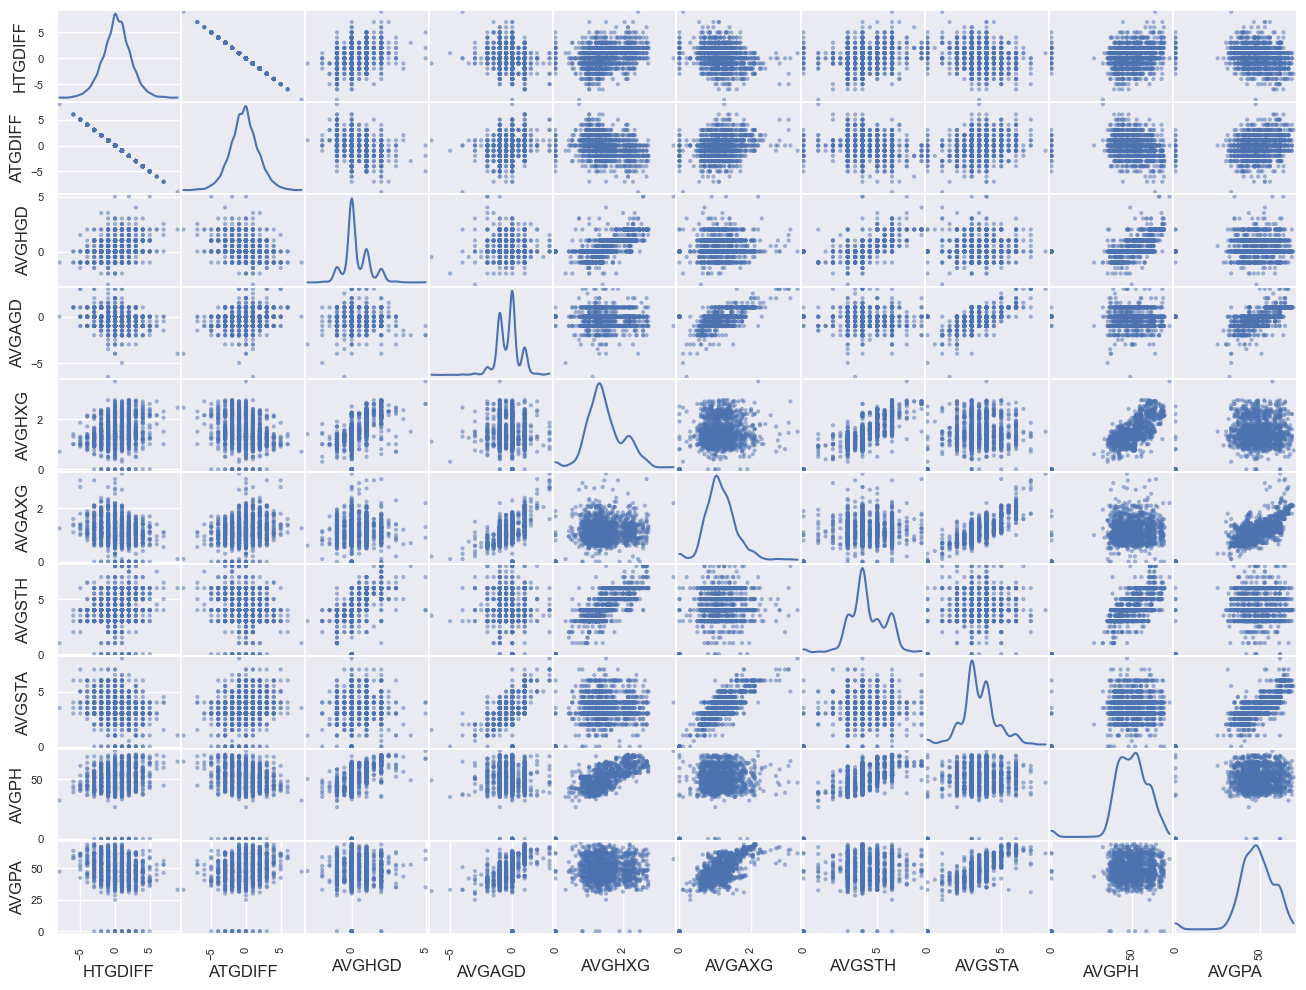

In [2813]:
# Visualize data
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

numerical_features = ["HTGDIFF", "ATGDIFF", "AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA"]
scatter_matrix(df[numerical_features], diagonal='kde', figsize=(16, 12))
plt.show()

In [2814]:
# Define the date cutoff for train/test split based on database
cutoff_date = "2025-02-15"

# Split data based on date
train_df = df[df["Date"] < cutoff_date]  # Train on matches before the cutoff
test_df = df[df["Date"] >= cutoff_date]  # Test on matches on or after the cutoff

# Define features and target variable
X_train = train_df[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA", "Home Team", "Away Team"]]
X_test = test_df[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA", "Home Team", "Away Team"]]

y_train = train_df["Result"]
y_test = test_df["Result"]

# Encode categorical target variable
result_encoder = LabelEncoder()
y_train_encoded = result_encoder.fit_transform(y_train)
y_test_encoded = result_encoder.transform(y_test)

# Ensure numeric columns are float64
X_train.loc[:, ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA"]] = X_train[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA"]].astype(float)
X_test.loc[:, ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA"]] = X_test[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA"]].astype(float)

scaler = StandardScaler()

X_train.loc[:, ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA"]] = scaler.fit_transform(X_train[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA"]])
X_test.loc[:, ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA"]] = scaler.transform(X_test[["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA"]])

# Train a Random Forest model / XGBoost model
xgb_model = XGBClassifier(
    learning_rate=0.005,  
    colsample_bytree = 0.5,
    subsample = 0.6,
    objective='multi:softprob', 
    n_estimators=1000, 
    max_depth=5, 
    gamma=5
)

# xgb_model = RandomForestClassifier(
#     n_estimators=1000,  # Number of trees in the forest
#     max_depth=5,        # Maximum depth of each tree
#     random_state=42
# )

eval_set = [(X_train, y_train_encoded), (X_test, y_test_encoded)]

xgb_model.fit(X_train, y_train_encoded, eval_set=eval_set, verbose=True)

y_pred = xgb_model.predict(X_test)

y_pred_train = xgb_model.predict(X_train)

[0]	validation_0-mlogloss:1.09780	validation_1-mlogloss:1.09780
[1]	validation_0-mlogloss:1.09698	validation_1-mlogloss:1.09698
[2]	validation_0-mlogloss:1.09619	validation_1-mlogloss:1.09622
[3]	validation_0-mlogloss:1.09532	validation_1-mlogloss:1.09538
[4]	validation_0-mlogloss:1.09452	validation_1-mlogloss:1.09427
[5]	validation_0-mlogloss:1.09379	validation_1-mlogloss:1.09340
[6]	validation_0-mlogloss:1.09300	validation_1-mlogloss:1.09262
[7]	validation_0-mlogloss:1.09224	validation_1-mlogloss:1.09189
[8]	validation_0-mlogloss:1.09162	validation_1-mlogloss:1.09110
[9]	validation_0-mlogloss:1.09101	validation_1-mlogloss:1.09051
[10]	validation_0-mlogloss:1.09035	validation_1-mlogloss:1.08984
[11]	validation_0-mlogloss:1.08961	validation_1-mlogloss:1.08925
[12]	validation_0-mlogloss:1.08883	validation_1-mlogloss:1.08838
[13]	validation_0-mlogloss:1.08811	validation_1-mlogloss:1.08752
[14]	validation_0-mlogloss:1.08731	validation_1-mlogloss:1.08658
[15]	validation_0-mlogloss:1.08659	

In [2815]:
# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)

accuracy_train = accuracy_score(y_train_encoded, y_pred_train)

print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))

# Decode predictions
y_pred_decoded = result_encoder.inverse_transform(y_pred)

# Create results dataframe
results_df = pd.DataFrame({
    "Home Team": test_df["Home Team"].values,
    "Away Team": test_df["Away Team"].values,
    "Result": y_test.values,
    "Predicted": y_pred_decoded
})

# Decode team names back from numerical values
results_df["Home Team"] = home_encoder.inverse_transform(results_df["Home Team"])
results_df["Away Team"] = away_encoder.inverse_transform(results_df["Away Team"])

XGB train Accuracy: 55.03%
XGB Accuracy: 58.54%


In [2816]:
# Feature Importance

importances = xgb_model.feature_importances_
feature_names = ["AVGHGD", "AVGAGD", "AVGHXG", "AVGAXG", "AVGSTH", "AVGSTA", "AVGPH", "AVGPA", "Home Team", "Away Team"]
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

dictionary = dict(zip(feature_names, importances))
sorted_dictionary=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)

names=[]
values=[]

for i in range(0, len(importances)):
    print('Feature Importance: {:35} {}%'.format(
        sorted_dictionary[i][0], np.round(sorted_dictionary[i][1]*100,4))
         )
    names.append(sorted_dictionary[i][0])
    values.append(np.round(sorted_dictionary[i][1]*100,4))

Feature Importance: AVGHXG                              13.305299758911133%
Feature Importance: AVGSTH                              12.915900230407715%
Feature Importance: AVGPA                               10.545299530029297%
Feature Importance: AVGHGD                              10.342599868774414%
Feature Importance: AVGAGD                              9.998200416564941%
Feature Importance: AVGPH                               9.559399604797363%
Feature Importance: AVGAXG                              9.27810001373291%
Feature Importance: AVGSTA                              8.368800163269043%
Feature Importance: Home Team                           7.935299873352051%
Feature Importance: Away Team                           7.751100063323975%


/var/folders/12/5y1ph4xx3v72zr1wc64m1yrh0000gq/T/ipykernel_84401/640132446.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(names, cum_values, '--bo', color='red', label="Cumulative Importance")


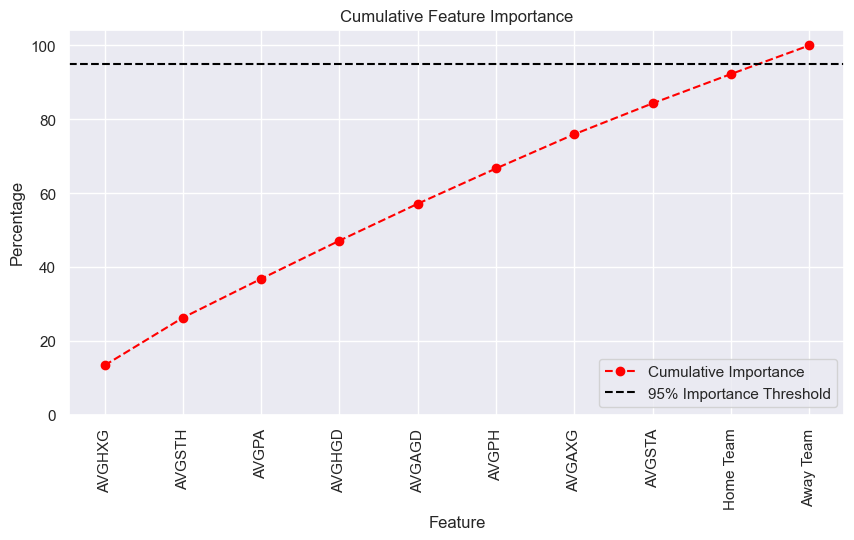

In [2817]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Compute cumulative importance
cum_values = np.cumsum(values)

# Get features contributing to 95% importance
values_over_95 = (cum_values > 95).sum()
columns_over_95 = names[-values_over_95:]

# Plot Cumulative Feature Importance
plt.figure(figsize=(10, 5))
plt.plot(names, cum_values, '--o', color='red', label="Cumulative Importance")

# Set importance threshold at 95%
plt.axhline(95, color='black', linestyle='dashed', label="95% Importance Threshold")

# Fix ylim definition
bottom, top = plt.ylim()  # Get current ylim
plt.ylim(0, top)  # Set lower limit to 0

plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Percentage')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.show()


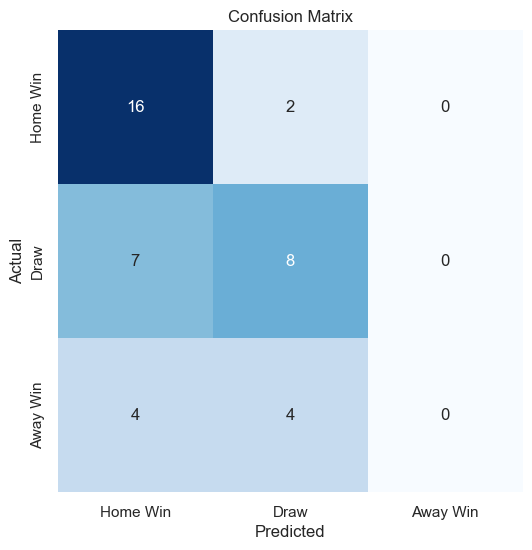

In [2818]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the results on the test set
y_pred = xgb_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Home Win', 'Draw', 'Away Win'], 
            yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

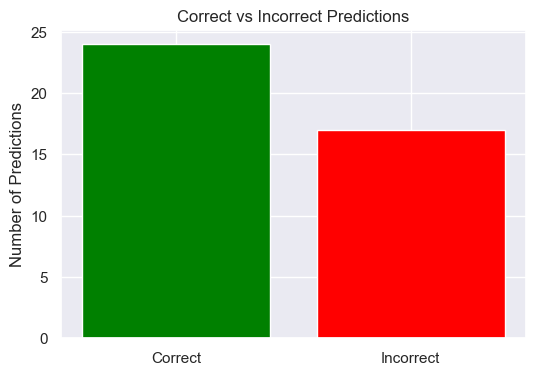

In [2819]:
#Accuracy Plot
import numpy as np

# Calculate correct and incorrect predictions
correct_predictions = np.sum(y_pred == y_test_encoded)
incorrect_predictions = np.sum(y_pred != y_test_encoded)

# Plot the proportion of correct vs. incorrect predictions
plt.figure(figsize=(6, 4))
plt.bar(['Correct', 'Incorrect'], [correct_predictions, incorrect_predictions], color=['green', 'red'])
plt.title('Correct vs Incorrect Predictions')
plt.ylabel('Number of Predictions')
plt.show()